In [1]:
# load important packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import astropy
import numpy as np
from astropy.io import fits, ascii
from astropy import units as u
from astropy.visualization import ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, RectangularAperture
import glob
from tqdm import tqdm

from mpdaf.obj import iter_spe
from mpdaf.obj import Cube, WCS, WaveCoord
from scipy.ndimage import rotate
from scipy.optimize import curve_fit

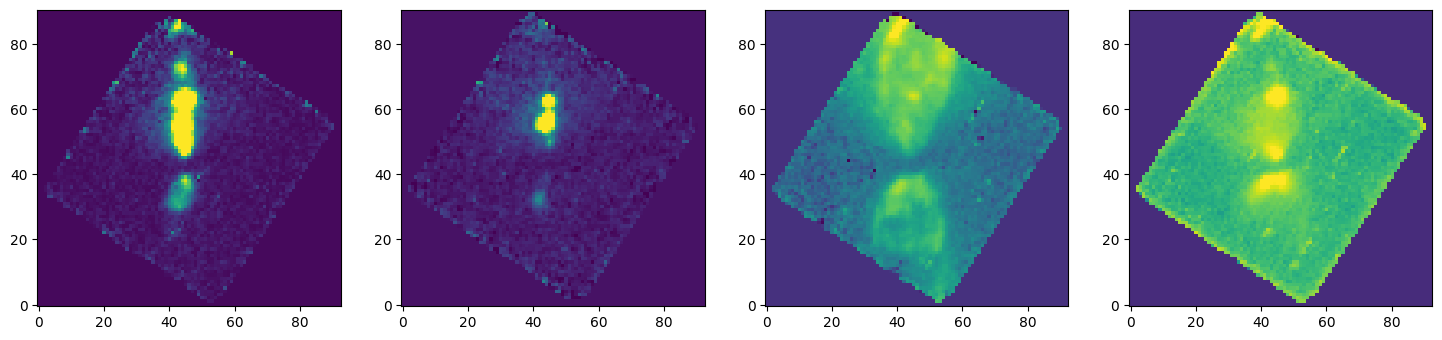

In [2]:
fe_file='b335_feII_alt.fits'
HI_file='b335_bralpha_alt.fits'
H2_file='b335_h2_alt.fits'
co_file='b335_co_summed_alt.fits'

fe_data=fits.getdata(fe_file)
HI_data=fits.getdata(HI_file)
H2_data=fits.getdata(H2_file)
co_data=fits.getdata(co_file)

fe_df=pd.DataFrame(fe_data)
fe_df.replace(np.nan, 0, inplace=True)
fe_data=fe_df.to_numpy()

HI_df=pd.DataFrame(HI_data)
HI_df.replace(np.nan, 0, inplace=True)
HI_data=HI_df.to_numpy()

H2_df=pd.DataFrame(H2_data)
H2_df.replace(np.nan, 0, inplace=True)
H2_data=H2_df.to_numpy()

co_df=pd.DataFrame(co_data)
co_df.replace(np.nan, 0, inplace=True)
co_data=co_df.to_numpy()

fe_image = rotate(fe_data,90, reshape=False)
HI_image = rotate(HI_data,90, reshape=False)
H2_image = rotate(H2_data,90, reshape=False)
co_image = rotate(co_data,90, reshape=False)

fig, (ax) = plt.subplots(1,4, figsize=(18,6))

plt.subplot(141)
#plt.imshow(image, origin='lower',aspect = 1, vmin = -1, vmax = 2, norm='linear')
plt.imshow(fe_image, origin='lower',aspect = 1, vmin = -1, vmax = 40, norm='linear')

plt.subplot(142)
#plt.imshow(image, origin='lower',aspect = 1, vmin = -1, vmax = 2, norm='linear')
plt.imshow(HI_image, origin='lower',aspect = 1, vmin = -1, vmax = 20, norm='linear')

plt.subplot(143)
#plt.imshow(image, origin='lower',aspect = 1, vmin = -1, vmax = 2, norm='linear')
plt.imshow(H2_image, origin='lower',aspect = 1, vmin = -1, vmax = 100, norm='asinh')

plt.subplot(144)
#plt.imshow(image, origin='lower',aspect = 1, vmin = -1, vmax = 2, norm='linear')
plt.imshow(co_image, origin='lower',aspect = 1, vmin = -1, vmax = 200, norm='asinh')

## Jet Width FWHM

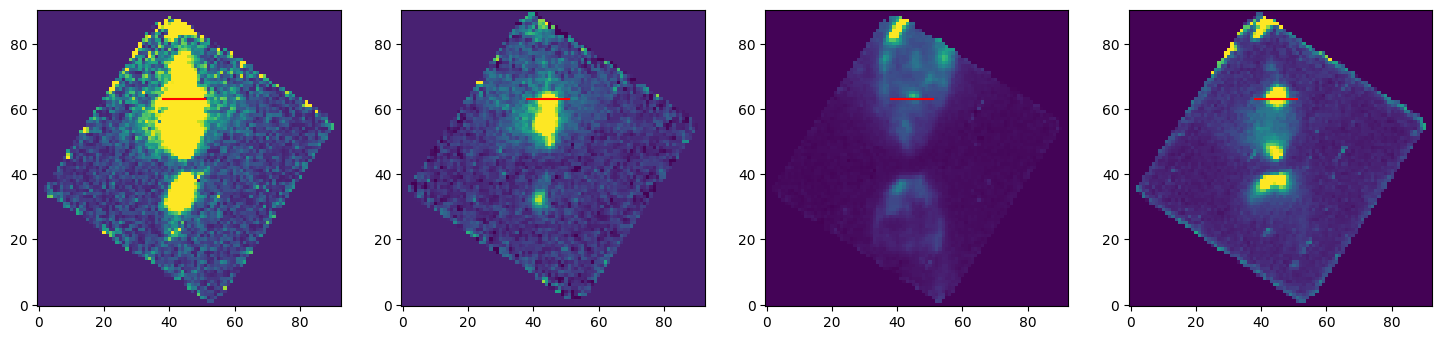

In [3]:
cut1x=np.arange(38,52,1)
cut1y=np.zeros(14)+63

fe_cutdata=fe_image[63,38:52]
HI_cutdata=HI_image[63,38:52]
H2_cutdata=H2_image[63,38:52]
co_cutdata=co_image[63,38:52]

fig, (ax) = plt.subplots(1,4, figsize=(18,6))

plt.subplot(141)
plt.imshow(fe_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(142)
plt.imshow(HI_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(143)
plt.imshow(H2_image, origin='lower',aspect = 1, vmin = -1, vmax = 100, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(144)
plt.imshow(co_image, origin='lower',aspect = 1, vmin = -1, vmax = 200, norm='linear')
plt.plot(cut1x, cut1y, color='red')

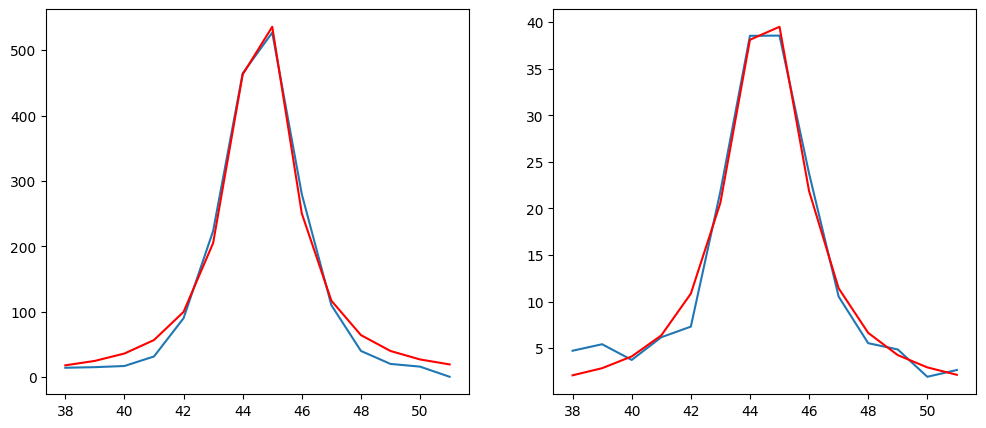

In [4]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def lorentz(x, *p):
    A, mu, sigma = p
    return A*((sigma**2)/(((x-mu)**2)+((sigma)**2)))

fe_p0 = [20, 45, 1]
fe_coeff, fe_var_matrix = curve_fit(lorentz, cut1x, fe_cutdata, p0=fe_p0)
fe_fit = lorentz(cut1x, *fe_coeff)

HI_p0 = [20, 45, 2]
HI_coeff, HI_var_matrix = curve_fit(lorentz, cut1x, HI_cutdata, p0=HI_p0)
HI_fit = lorentz(cut1x, *HI_coeff)

fig, ax = plt.subplots(1,2,figsize=(12,5))

plt.subplot(121)
plt.plot(cut1x, fe_cutdata)
plt.plot(cut1x, fe_fit, color='red')

plt.subplot(122)
plt.plot(cut1x, HI_cutdata)
plt.plot(cut1x, HI_fit, color='red')

In [5]:
fe_sigma=fe_coeff[2]
fe_width_unc=fe_var_matrix[2][2]
print('[FeII] jet FWHM (arcsec): ', fe_sigma*2.355*0.1)
print('[FeII] jet width uncertainty (arcsec)', fe_width_unc*0.1)
print('[FeII] jet FWHM (au): ', fe_sigma*2.355*0.1*165)
print('[FeII] jet deconvolved FWHM (arcsec): ', np.sqrt((fe_sigma*2.355*0.1)**2-(0.21**2)))
print('[FeII] jet deconvolved FWHM (au): ', np.sqrt((fe_sigma*2.355*0.1)**2-(0.21**2))*165)

HI_sigma=HI_coeff[2]
HI_width_unc=HI_var_matrix[2][2]
print('HI jet FWHM (arcsec): ', HI_sigma*2.355*0.1)
print('HI jet width uncertainty (arcsec)', HI_width_unc*0.1)
print('HI jet FWHM (au): ', HI_sigma*2.355*0.1*165)
print('HI jet deconvolved FWHM (arcsec): ', np.sqrt((HI_sigma*2.355*0.1)**2-(0.21**2)))
print('HI jet deconvolved FWHM (au): ', np.sqrt((HI_sigma*2.355*0.1)**2-(0.21**2))*165)

[FeII] jet FWHM (arcsec):  0.2785130609628626
[FeII] jet width uncertainty (arcsec) 0.0003811012362427851
[FeII] jet FWHM (au):  45.954655058872326
[FeII] jet deconvolved FWHM (arcsec):  0.1829467822261524
[FeII] jet deconvolved FWHM (au):  30.186219067315147
HI jet FWHM (arcsec):  0.3462614086120974
HI jet width uncertainty (arcsec) 0.0007271263639868191
HI jet FWHM (au):  57.13313242099608
HI jet deconvolved FWHM (arcsec):  0.27531248263388625
HI jet deconvolved FWHM (au):  45.42655963459123


## Lower Jet Width FWHM

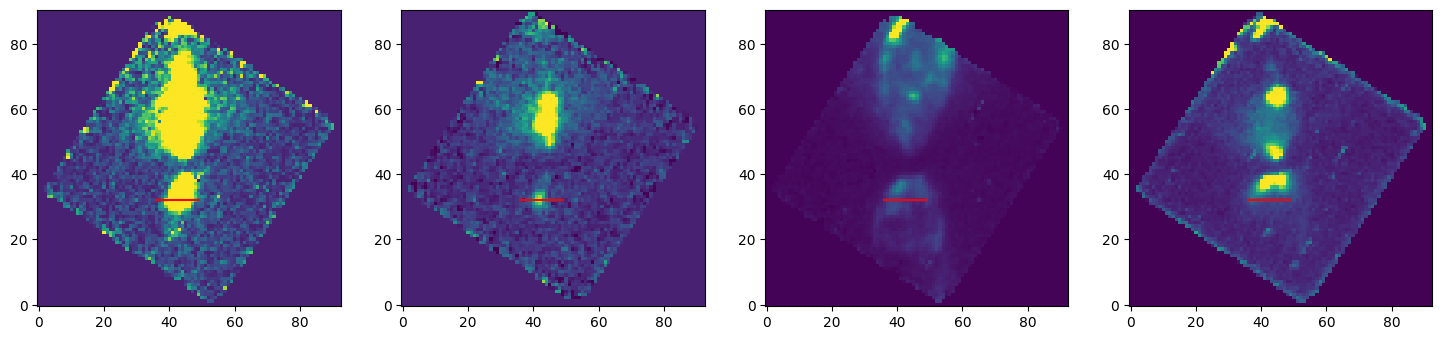

In [6]:
cut1x=np.arange(36,50,1)
cut1y=np.zeros(14)+32

fe_cutdata=fe_image[32,36:50]
HI_cutdata=HI_image[32,36:50]
H2_cutdata=H2_image[32,36:50]
co_cutdata=co_image[32,36:50]

fig, (ax) = plt.subplots(1,4, figsize=(18,6))

plt.subplot(141)
plt.imshow(fe_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(142)
plt.imshow(HI_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(143)
plt.imshow(H2_image, origin='lower',aspect = 1, vmin = -1, vmax = 100, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(144)
plt.imshow(co_image, origin='lower',aspect = 1, vmin = -1, vmax = 200, norm='linear')
plt.plot(cut1x, cut1y, color='red')

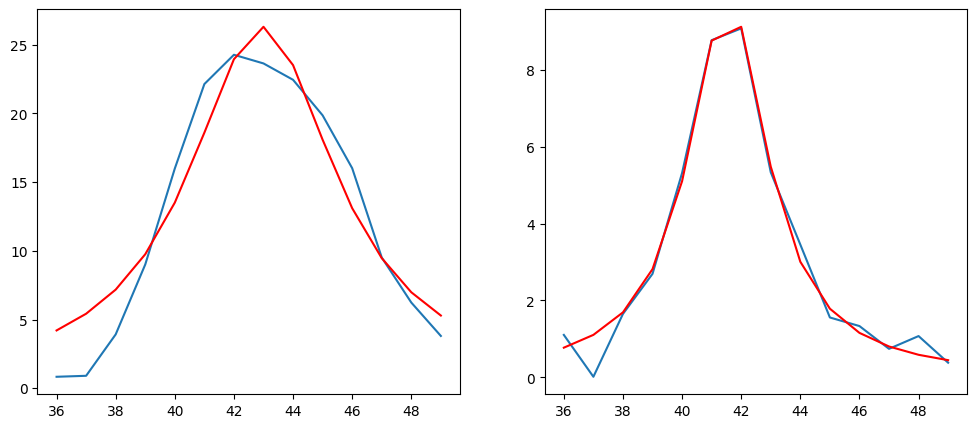

In [7]:
fe_p0 = [20, 42, 1]
fe_coeff, fe_var_matrix = curve_fit(lorentz, cut1x, fe_cutdata, p0=fe_p0)
fe_fit = lorentz(cut1x, *fe_coeff)

HI_p0 = [20, 42, 2]
HI_coeff, HI_var_matrix = curve_fit(lorentz, cut1x, HI_cutdata, p0=HI_p0)
HI_fit = lorentz(cut1x, *HI_coeff)

fig, ax = plt.subplots(1,2,figsize=(12,5))

plt.subplot(121)
plt.plot(cut1x, fe_cutdata)
plt.plot(cut1x, fe_fit, color='red')

plt.subplot(122)
plt.plot(cut1x, HI_cutdata)
plt.plot(cut1x, HI_fit, color='red')

In [8]:
fe_sigma=fe_coeff[2]
fe_width_unc=fe_var_matrix[2][2]
print('[FeII] jet FWHM (arcsec): ', fe_sigma*2.355*0.1)
print('[FeII] jet width uncertainty (arcsec)', fe_width_unc*0.1)
print('[FeII] jet FWHM (au): ', fe_sigma*2.355*0.1*165)

print('[FeII] jet deconvolved FWHM (arcsec): ', np.sqrt((fe_sigma*2.355*0.1)**2-(0.21**2)))
print('[FeII] jet deconvolved FWHM (au): ', np.sqrt((fe_sigma*2.355*0.1)**2-(0.21**2))*165)

HI_sigma=HI_coeff[2]
print('HI jet FWHM (arcsec): ', HI_sigma*2.355*0.1)
print('HI jet FWHM (au): ', HI_sigma*2.355*0.1*165)

print('HI jet deconvolved FWHM (arcsec): ', np.sqrt((HI_sigma*2.355*0.1)**2-(0.21**2)))
print('HI jet deconvolved FWHM (au): ', np.sqrt((HI_sigma*2.355*0.1)**2-(0.21**2))*165)

[FeII] jet FWHM (arcsec):  0.7145471417968343
[FeII] jet width uncertainty (arcsec) 0.010702093374167509
[FeII] jet FWHM (au):  117.90027839647766
[FeII] jet deconvolved FWHM (arcsec):  0.6829916674821335
[FeII] jet deconvolved FWHM (au):  112.69362513455202
HI jet FWHM (arcsec):  0.3826236127955991
HI jet FWHM (au):  63.13289611127385
HI jet deconvolved FWHM (arcsec):  0.3198450078846886
HI jet deconvolved FWHM (au):  52.77442630097362


## Northern Knot FWHM (upper jet)

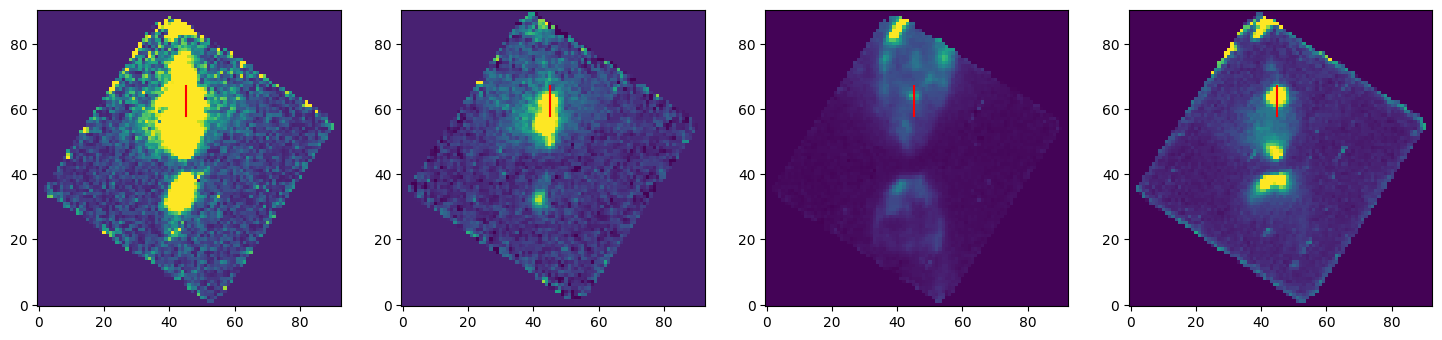

In [9]:
cut1x=np.zeros(10)+45
cut1y=np.arange(58,68,1)

fe_cutdata=fe_image[58:68,45]
HI_cutdata=HI_image[58:68,45]
H2_cutdata=H2_image[58:68,45]
co_cutdata=co_image[58:68,45]

fig, (ax) = plt.subplots(1,4, figsize=(18,6))

plt.subplot(141)
plt.imshow(fe_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(142)
plt.imshow(HI_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(143)
plt.imshow(H2_image, origin='lower',aspect = 1, vmin = -1, vmax = 100, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(144)
plt.imshow(co_image, origin='lower',aspect = 1, vmin = -1, vmax = 200, norm='linear')
plt.plot(cut1x, cut1y, color='red')

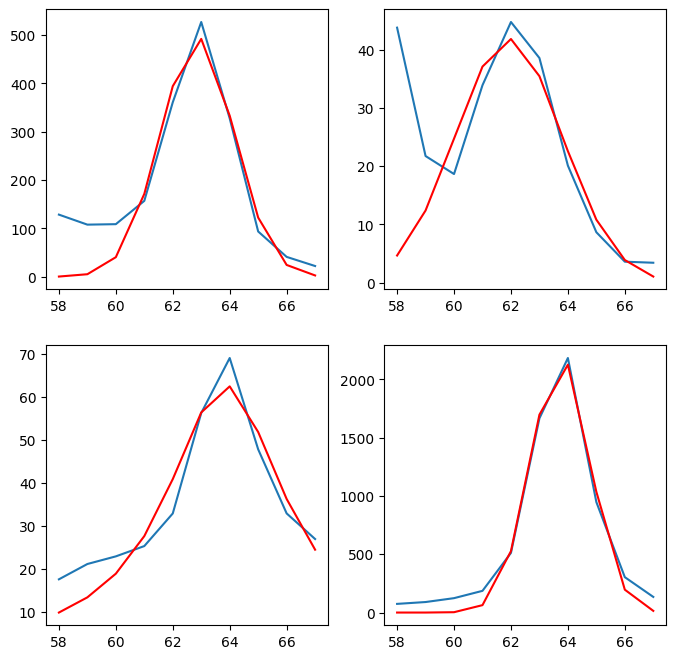

In [10]:
fe_p0 = [500, 63, 1]
fe_coeff, fe_var_matrix = curve_fit(gauss, cut1y, fe_cutdata, p0=fe_p0)
fe_fit = gauss(cut1y, *fe_coeff)

HI_p0 = [40, 62, 1]
HI_coeff, HI_var_matrix = curve_fit(gauss, cut1y[1:8], HI_cutdata[1:8], p0=HI_p0)
HI_fit = gauss(cut1y, *HI_coeff)

H2_p0 = [100, 63, 1]
H2_coeff, fe_var_matrix = curve_fit(lorentz, cut1y, H2_cutdata, p0=H2_p0)
H2_fit = lorentz(cut1y, *H2_coeff)

co_p0 = [2000, 63, 1]
co_coeff, co_var_matrix = curve_fit(gauss, cut1y, co_cutdata, p0=co_p0)
co_fit = gauss(cut1y, *co_coeff)

fig, ax = plt.subplots(2,2,figsize=(8,8))

plt.subplot(221)
plt.plot(cut1y, fe_cutdata)
plt.plot(cut1y, fe_fit, color='red')

plt.subplot(222)
plt.plot(cut1y, HI_cutdata)
plt.plot(cut1y, HI_fit, color='red')

plt.subplot(223)
plt.plot(cut1y, H2_cutdata)
plt.plot(cut1y, H2_fit, color='red')

plt.subplot(224)
plt.plot(cut1y, co_cutdata)
plt.plot(cut1y, co_fit, color='red')

In [11]:
print(fe_coeff[0]/HI_coeff[0])

11.816435710433296


In [12]:
fe_sigma=fe_coeff[2]
fe_mu=fe_coeff[1]
fe_distance=(fe_mu-44)*0.1*165
fe_unc=fe_sigma*0.1*165
print('[FeII] knot FWHM (pixels): ', fe_sigma*2.355)
print('[FeII] knot FWHM (au): ', fe_sigma*2.355*0.1*165)
print('[FeII] knot center pixel: ', fe_mu)
print('[FeII] knot distance (au): ', fe_distance)
print('[FeII] knot distance uncertainty', fe_unc)

HI_sigma=HI_coeff[2]
HI_mu=HI_coeff[1]
HI_distance=(HI_mu-44)*0.1*165
HI_unc=HI_sigma*0.1*165
print('HI knot FWHM (pixels): ', HI_sigma*2.355)
print('HI knot FWHM (au): ', HI_sigma*2.355*0.1*165)
print('HI knot center pixel: ', HI_mu)
print('HI knot distance (au): ', HI_distance)
print('HI knot distance uncertainty', HI_unc)

H2_sigma=H2_coeff[2]
H2_mu=H2_coeff[1]
H2_distance=(H2_mu-44)*0.1*165
H2_unc=H2_sigma*0.1*165
print('H2 knot FWHM (pixels): ', H2_sigma*2.355)
print('H2 knot FWHM (au): ', H2_sigma*2.355*0.1*165)
print('H2 knot center pixel: ', H2_mu)
print('H2 knot distance (au): ', H2_distance)
print('H2 knot distance uncertainty', H2_unc)

co_sigma=co_coeff[2]
co_mu=co_coeff[1]
co_distance=(co_mu-44)*0.1*165
co_unc=co_sigma*0.1*165
print('co knot FWHM (pixels): ', co_sigma*2.355)
print('co knot FWHM (au): ', co_sigma*2.355*0.1*165)
print('co knot center pixel: ', co_mu)
print('co knot distance (au): ', co_distance)
print('H2 knot distance uncertainty', co_unc)

[FeII] knot FWHM (pixels):  3.011266482494775
[FeII] knot FWHM (au):  49.685896961163785
[FeII] knot center pixel:  62.86215300926164
[FeII] knot distance (au):  311.22552465281706
[FeII] knot distance uncertainty 21.0980454187532
HI knot FWHM (pixels):  4.406661092580862
HI knot FWHM (au):  72.70990802758422
HI knot center pixel:  61.920603649352714
HI knot distance (au):  295.6899602143198
HI knot distance uncertainty 30.87469555311432
H2 knot FWHM (pixels):  5.949007227963446
H2 knot FWHM (au):  98.15861926139686
H2 knot center pixel:  63.84438843633217
H2 knot distance (au):  327.4324091994808
H2 knot distance uncertainty 41.680942361527336
co knot FWHM (pixels):  2.4230106606574098
co knot FWHM (au):  39.97967590084726
co knot center pixel:  63.73873294083494
co knot distance (au):  325.6890935237766
H2 knot distance uncertainty 16.976507813523252


## Southern knot FWHM (upper jet)

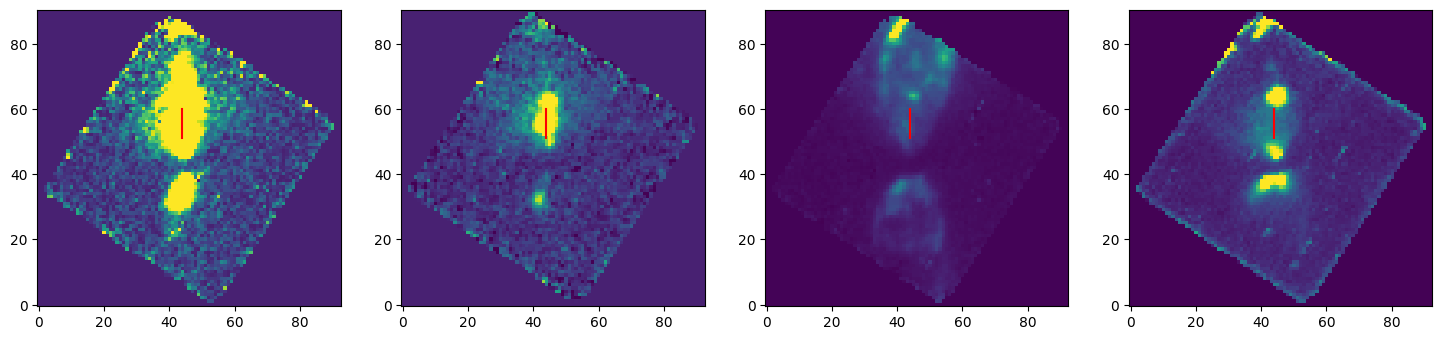

In [13]:
cut1x=np.zeros(10)+44
cut1y=np.arange(51,61,1)

fe_cutdata=fe_image[51:61,44]
HI_cutdata=HI_image[51:61,44]
H2_cutdata=H2_image[51:61,44]
co_cutdata=co_image[51:61,44]

fig, (ax) = plt.subplots(1,4, figsize=(18,6))

plt.subplot(141)
plt.imshow(fe_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(142)
plt.imshow(HI_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(143)
plt.imshow(H2_image, origin='lower',aspect = 1, vmin = -1, vmax = 100, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(144)
plt.imshow(co_image, origin='lower',aspect = 1, vmin = -1, vmax = 200, norm='linear')
plt.plot(cut1x, cut1y, color='red')

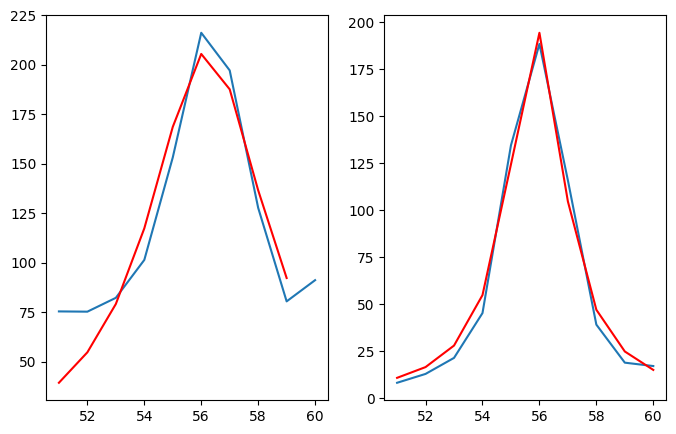

In [14]:
fe_p0 = [250, 57, 1]
fe_coeff, fe_var_matrix = curve_fit(lorentz, cut1y[0:9], fe_cutdata[0:9], p0=fe_p0)
fe_fit = lorentz(cut1y[0:9], *fe_coeff)

HI_p0 = [200, 57, 1]
HI_coeff, HI_var_matrix = curve_fit(lorentz, cut1y, HI_cutdata, p0=HI_p0)
HI_fit = lorentz(cut1y, *HI_coeff)

#H2_p0 = [10, 58, 1]
#H2_coeff, fe_var_matrix = curve_fit(gauss, cut1y, H2_cutdata, p0=H2_p0)
#H2_fit = gauss(cut1y, *H2_coeff)

#co_p0 = [10, 58, 1]
#co_coeff, co_var_matrix = curve_fit(gauss, cut1y, co_cutdata, p0=co_p0)
#co_fit = gauss(cut1y, *co_coeff)

fig, ax = plt.subplots(1,2,figsize=(8,5))

plt.subplot(121)
plt.plot(cut1y, fe_cutdata)
plt.plot(cut1y[0:9], fe_fit, color='red')

plt.subplot(122)
plt.plot(cut1y, HI_cutdata)
plt.plot(cut1y, HI_fit, color='red')

#plt.subplot(223)
#plt.plot(cut1y, H2_cutdata)
#plt.plot(cut1y, H2_fit, color='red')

#plt.subplot(224)
#plt.plot(cut1y, co_cutdata)
#plt.plot(cut1y, co_fit, color='red')

In [15]:
print(fe_coeff[0]/HI_coeff[0])

1.0548701872071924


In [16]:
fe_sigma=fe_coeff[2]
fe_mu=fe_coeff[1]
fe_distance=(fe_mu-44)*0.1*165
fe_unc=fe_sigma*0.1*165
print('[FeII] knot FWHM (pixels): ', fe_sigma*2.355)
print('[FeII] knot FWHM (au): ', fe_sigma*2.355*0.1*165)
print('[FeII] knot center pixel: ', fe_mu)
print('[FeII] knot distance (au): ', fe_distance)
print('[FeII] knot distance uncertainty', fe_unc)

HI_sigma=HI_coeff[2]
HI_mu=HI_coeff[1]
HI_distance=(HI_mu-44)*0.1*165
HI_unc=HI_sigma*0.1*165
print('HI knot FWHM (pixels): ', HI_sigma*2.355)
print('HI knot FWHM (au): ', HI_sigma*2.355*0.1*165)
print('HI knot center pixel: ', HI_mu)
print('HI knot distance (au): ', HI_distance)
print('HI knot distance uncertainty', HI_unc)

[FeII] knot FWHM (pixels):  5.92484725571789
[FeII] knot FWHM (au):  97.75997971934518
[FeII] knot center pixel:  56.19646361921205
[FeII] knot distance (au):  201.24164971699878
[FeII] knot distance uncertainty 41.511668670634904
HI knot FWHM (pixels):  2.7834534145621777
HI knot FWHM (au):  45.92698134027593
HI knot center pixel:  55.8964415693115
HI knot distance (au):  196.29128589363975
HI knot distance uncertainty 19.50190290457577


## Cut along entire jet

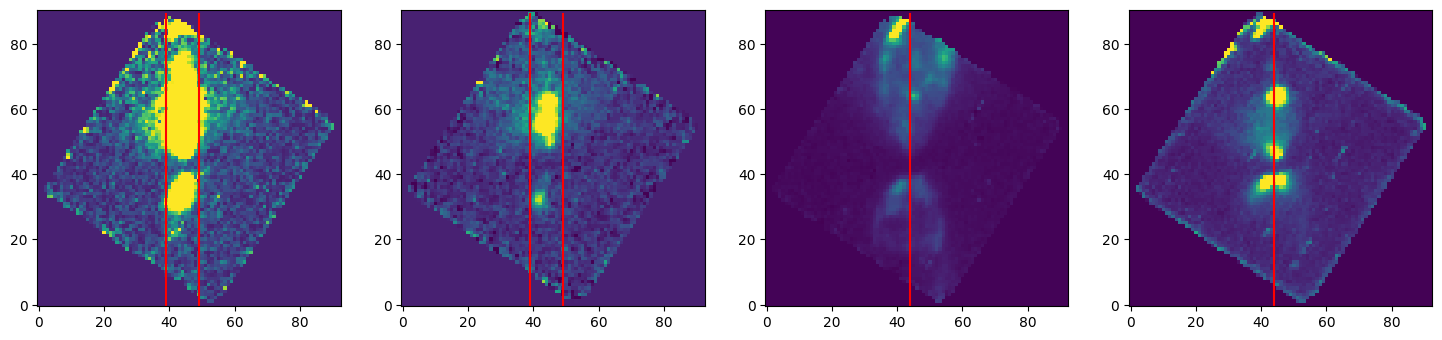

In [17]:
cut1x=np.zeros(90)+44
cut1y=np.arange(0,90,1)

fe_cutdata=fe_image[0:90,42:52]
HI_cutdata=HI_image[0:90,42:52]
H2_cutdata=H2_image[0:90,42:52]
co_cutdata=co_image[0:90,42:52]

fig, (ax) = plt.subplots(1,4, figsize=(18,6))

plt.subplot(141)
plt.imshow(fe_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
#plt.plot(cut1x, cut1y, color='red')
plt.plot(cut1x-5, cut1y, color='red')
plt.plot(cut1x+5, cut1y, color='red')

plt.subplot(142)
plt.imshow(HI_image, origin='lower',aspect = 1, vmin = -1, vmax = 10, norm='linear')
#plt.plot(cut1x, cut1y, color='red')
plt.plot(cut1x-5, cut1y, color='red')
plt.plot(cut1x+5, cut1y, color='red')

plt.subplot(143)
plt.imshow(H2_image, origin='lower',aspect = 1, vmin = -1, vmax = 100, norm='linear')
plt.plot(cut1x, cut1y, color='red')

plt.subplot(144)
plt.imshow(co_image, origin='lower',aspect = 1, vmin = -1, vmax = 200, norm='linear')
plt.plot(cut1x, cut1y, color='red')

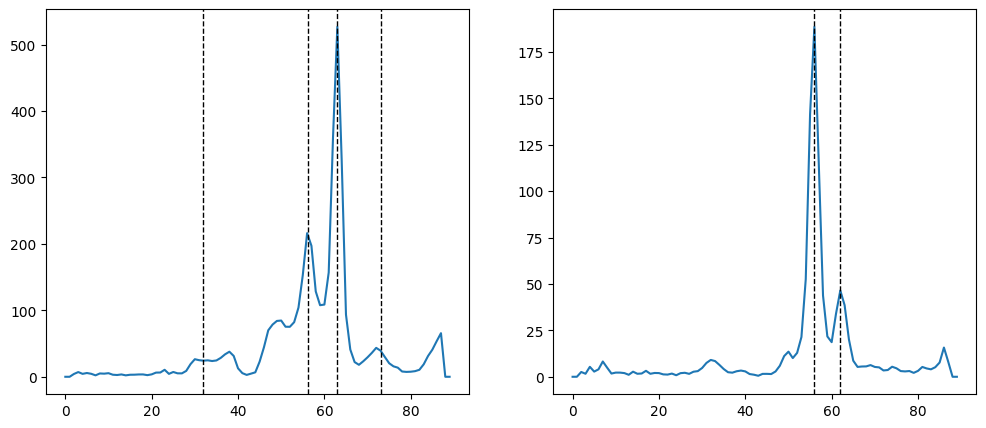

In [18]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

plt.subplot(121)
plt.plot(cut1y, np.nanmax(fe_cutdata, axis=1))
plt.axvline(x=fe_mu, color='black', linestyle='dashed', linewidth=1)
plt.axvline(x=63, color='black', linestyle='dashed', linewidth=1)
plt.axvline(x=73, color='black', linestyle='dashed', linewidth=1)
plt.axvline(x=32, color='black', linestyle='dashed', linewidth=1)
#plt.ylim(-2,5)

plt.subplot(122)
plt.plot(cut1y, np.nanmax(HI_cutdata, axis=1))
plt.axvline(x=HI_mu, color='black', linestyle='dashed', linewidth=1)
plt.axvline(x=62, color='black', linestyle='dashed', linewidth=1)
#plt.ylim(-1,10)

In [19]:
def timescale(distance, inclination):
    launch_time = (((distance)*(1.5e8))/(100*np.sin(inclination*(np.pi/180))))/(np.pi*1e7)
    return launch_time

In [20]:
timescale(315, 83.5)

15.137447821468635

In [21]:
timescale(199, 83.5)

9.563022591975423

In [22]:
#faint farthest knot
distance=(73-45)*0.1*165
timescale(distance, 83.5)

22.201590138154007